In [1]:
#These steps are mostly followed by 
#https://medium.com/analytics-vidhya/understanding-and-implementation-of-residual-networks-resnets-b80f9a507b9c
#and
#https://mldlcvmjw.tistory.com/294
#which are both using Resnet50 as an example.
#Also, this is based on the original paper that I read
#https://arxiv.org/pdf/1512.03385.pdf
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras import layers, Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Activation, Add, AvgPool2D, BatchNormalization, Conv2D, Dense, Flatten, Input, MaxPool2D, ZeroPadding2D

In [2]:
def identity_block(x, filters):
    """
    This is a block when size does not change.
    It is on second blocks and onward.
    """
    
    #This is for adding up with residual
    x_i = x
    f1, f2 = filters
    
    #First Part
    x = Conv2D(f1, kernel_size =(3,3), padding = 'same', strides = (1,1))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #Second Part
    x = Conv2D(f2, kernel_size =(3,3), padding = 'same', strides = (1,1))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #Adding residual and original data
    x = Add()([x, x_i])
    x = Activation('relu')(x)
    
    return x

In [3]:
def conv_block(x, filters,s):
    """
    This is a block when size needs to change.
    It is on the first block.
    """
    
    #This is for adding up with residual
    x_i = x
    f1, f2 = filters
    
    #First Part
    x = Conv2D(f1, kernel_size =(3,3), padding = 'same', strides = (s,s))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #Second Part
    x = Conv2D(f2, kernel_size =(3,3), padding = 'same', strides = (1,1))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #Changing the orignial input
    x_i = Conv2D(f1, kernel_size =(3,3), padding = 'same', strides = (s,s))(x_i)
    x_i = BatchNormalization()(x_i)
    
    #Adding residual and original data
    x = Add()([x, x_i])
    x = Activation('relu')(x)
    
    return x

In [4]:
def res34():
    inputting = Input(shape = (224,224,3))
    
    #With the stride = 2, this will result in first output to have a padding of 1
    x = ZeroPadding2D(padding = (3,3))(inputting)
    
    
    #conv1 [(224-7+2*3)/2]+1
    x = Conv2D(64, kernel_size = (7,7), strides = (2,2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #conv2
    x = MaxPool2D(pool_size = (3,3), strides = (2,2))(x)
    x = conv_block(x,(64,64), 1)
    x = identity_block(x, (64,64))
    x = identity_block(x, (64,64))
    
    #conv3
    x = conv_block(x,(128,128), 2)
    x = identity_block(x, (128,128))
    x = identity_block(x, (128,128))
    x = identity_block(x, (128,128))
    
    #conv4
    x = conv_block(x,(256,256), 2)
    x = identity_block(x, (256,256))
    x = identity_block(x, (256,256))
    x = identity_block(x, (256,256))
    x = identity_block(x, (256,256))
    x = identity_block(x, (256,256))
    
    #conv5
    x = conv_block(x,(512,512), 2)
    x = identity_block(x, (512,512))
    x = identity_block(x, (512,512))
    
    #Average
    x = AvgPool2D(pool_size = (7,7))(x)
    
    #Output
    x = Flatten()(x)
    x = Dense(2, activation = 'softmax')(x)
    
    model = Model(inputs = inputting, outputs=x, name = 'Resnet34')
    
    return model

In [5]:
#Below is just testing using a dataset from
#https://www.kaggle.com/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification

In [6]:
train_dir  = "../input/muffin-vs-chihuahua-image-classification/train"
test_dir   = "../input/muffin-vs-chihuahua-image-classification/test"

In [7]:
#Makes data paths into Dataframe with labels
def making_df(dir):
    path = []
    classes = []
    
    dirs = os.listdir(dir)
    for stuff in dirs:
        ldir = os.path.join(dir,stuff)
        ldirs = os.listdir(ldir)
        for img in ldirs:
            img_dir = os.path.join(ldir,img)
            path.append(img_dir)
            classes.append(stuff)
    
    d = {'file path': path, 'class': classes}
    file_df = pd.DataFrame(d)
    return file_df

#Splitting data into training, validation and test data 
def ttv_split(tr_dir, ts_dir):
    #Train Data
    train_df = making_df(tr_dir)
    
    #Valid and Test Data
    tv_df = making_df(ts_dir)
    strat = tv_df['class'] #Ensures that the relative class frequencies is approximately preserved in each train and validation fold.
    valid_df, test_df = train_test_split(tv_df, train_size = 0.5, shuffle = True, random_state = 26, stratify = strat)
    
    return train_df, valid_df, test_df

In [8]:
def create_model(train_df, valid_df, test_df, batch_size):
    
    img_size = (224,224)
    color = 'rgb'
    
    tr_gen = ImageDataGenerator(rescale=1./255,shear_range = 0.2, zoom_range = 0.2)
    ts_gen = ImageDataGenerator(rescale=1./255)
    
    train_gen = tr_gen.flow_from_dataframe(train_df,x_col = 'file path',y_col = 'class',
                                          target_size = img_size, color_mode = color,
                                          batch_size = batch_size,
                                          class_mode = 'categorical',shuffle = True)
    
    valid_gen = tr_gen.flow_from_dataframe(valid_df,x_col = 'file path',y_col = 'class',
                                          target_size = img_size, color_mode = color,
                                          batch_size = batch_size,
                                          class_mode = 'categorical',shuffle = True)
    
    test_gen = tr_gen.flow_from_dataframe(test_df,x_col = 'file path',y_col = 'class',
                                          target_size = img_size, color_mode = color,
                                          batch_size = batch_size,
                                          class_mode = 'categorical',shuffle = True)
    
    return train_gen, valid_gen, test_gen

In [9]:
train_df, valid_df, test_df = ttv_split(train_dir, test_dir)

In [10]:
train_gen, valid_gen, test_gen = create_model(train_df, valid_df, test_df, 32)

Found 4733 validated image filenames belonging to 2 classes.
Found 592 validated image filenames belonging to 2 classes.
Found 592 validated image filenames belonging to 2 classes.


In [11]:
model = res34()

2023-01-05 09:01:24.405060: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-05 09:01:24.548417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-05 09:01:24.549209: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-05 09:01:24.550813: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights = True)

In [13]:
model.summary()

Model: "Resnet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
___________________________________________________________________________________________

In [14]:
model.fit(x=train_gen, validation_data = valid_gen,epochs = 15,batch_size = 16)

2023-01-05 09:01:29.045862: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2023-01-05 09:01:34.378736: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


148/148 [==============================] - 161s 1s/step - loss: 0.5763 - accuracy: 0.7847 - val_loss: 6.0911 - val_accuracy: 0.5405
Epoch 2/15
148/148 [==============================] - 119s 808ms/step - loss: 0.4017 - accuracy: 0.8377 - val_loss: 4.0897 - val_accuracy: 0.5591
Epoch 3/15
148/148 [==============================] - 120s 813ms/step - loss: 0.3789 - accuracy: 0.8483 - val_loss: 3.1734 - val_accuracy: 0.6334
Epoch 4/15
148/148 [==============================] - 122s 822ms/step - loss: 0.3444 - accuracy: 0.8603 - val_loss: 5.7165 - val_accuracy: 0.5473
Epoch 5/15
148/148 [==============================] - 124s 836ms/step - loss: 0.3309 - accuracy: 0.8779 - val_loss: 1.1794 - val_accuracy: 0.6166
Epoch 6/15
148/148 [==============================] - 122s 824ms/step - loss: 0.2904 - accuracy: 0.8893 - val_loss: 1.9684 - val_accuracy: 0.5963
Epoch 7/15
148/148 [==============================] - 121s 820ms/step - loss: 0.2685 - accuracy: 0.8908 - val_loss: 8.6835 - val_accuracy:

In [15]:
prediction = model.predict(test_gen)

In [16]:
prediction

array([[0.9431565 , 0.05684351],
       [0.8685728 , 0.13142724],
       [0.34693614, 0.6530639 ],
       ...,
       [0.1362913 , 0.8637087 ],
       [0.96754795, 0.03245204],
       [0.9839256 , 0.01607438]], dtype=float32)

In [17]:
test_data = {
    'class': [],
}

pred_data = {
    'class': [],
}

g_dict = test_gen.class_indices
labels = list(g_dict.keys())
images, classes = next(test_gen)

length = len(classes)

for i in range(length):
    index = np.argmax(classes[i])
    test_data['class'] += [labels[index]]
    indices = np.argmax(prediction[i])
    pred_data['class'] += [labels[indices]]
    
test_df = pd.DataFrame(test_data)
pred_df = pd.DataFrame(pred_data)

[[14  5]
 [ 8  5]]
              precision    recall  f1-score   support

   chihuahua       0.64      0.74      0.68        19
      muffin       0.50      0.38      0.43        13

    accuracy                           0.59        32
   macro avg       0.57      0.56      0.56        32
weighted avg       0.58      0.59      0.58        32



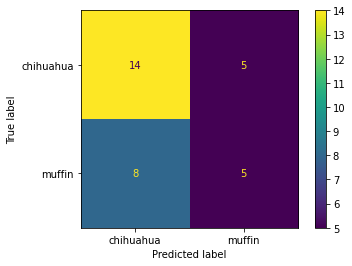

In [18]:
cm = confusion_matrix(test_df, pred_df, labels = ['chihuahua','muffin'])
cr = classification_report(test_df, pred_df, target_names=['chihuahua','muffin'])
print(cm)
print(cr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['chihuahua','muffin'])
disp.plot()
plt.show()

In [19]:
def show_images_test(gen,pred):
    g_dict = gen.class_indices
    labels = list(g_dict.keys())
    images, classes = next(gen)
    
    length = len(classes)
    sample = min(length, 25)
    
    plt.figure(figsize= (20,20))
    
    for i in range(sample):
        plt.subplot(5,5, i+1)
        image = images[i]
        plt.imshow(image)
        index = np.argmax(classes[i])
        class_name = labels[index]
        indices = np.argmax(pred[i])
        pred_name = labels[indices]
        plt.title(class_name+'   '+pred_name, color = 'black', fontsize = 12)
        plt.axis('off')
    plt.show()

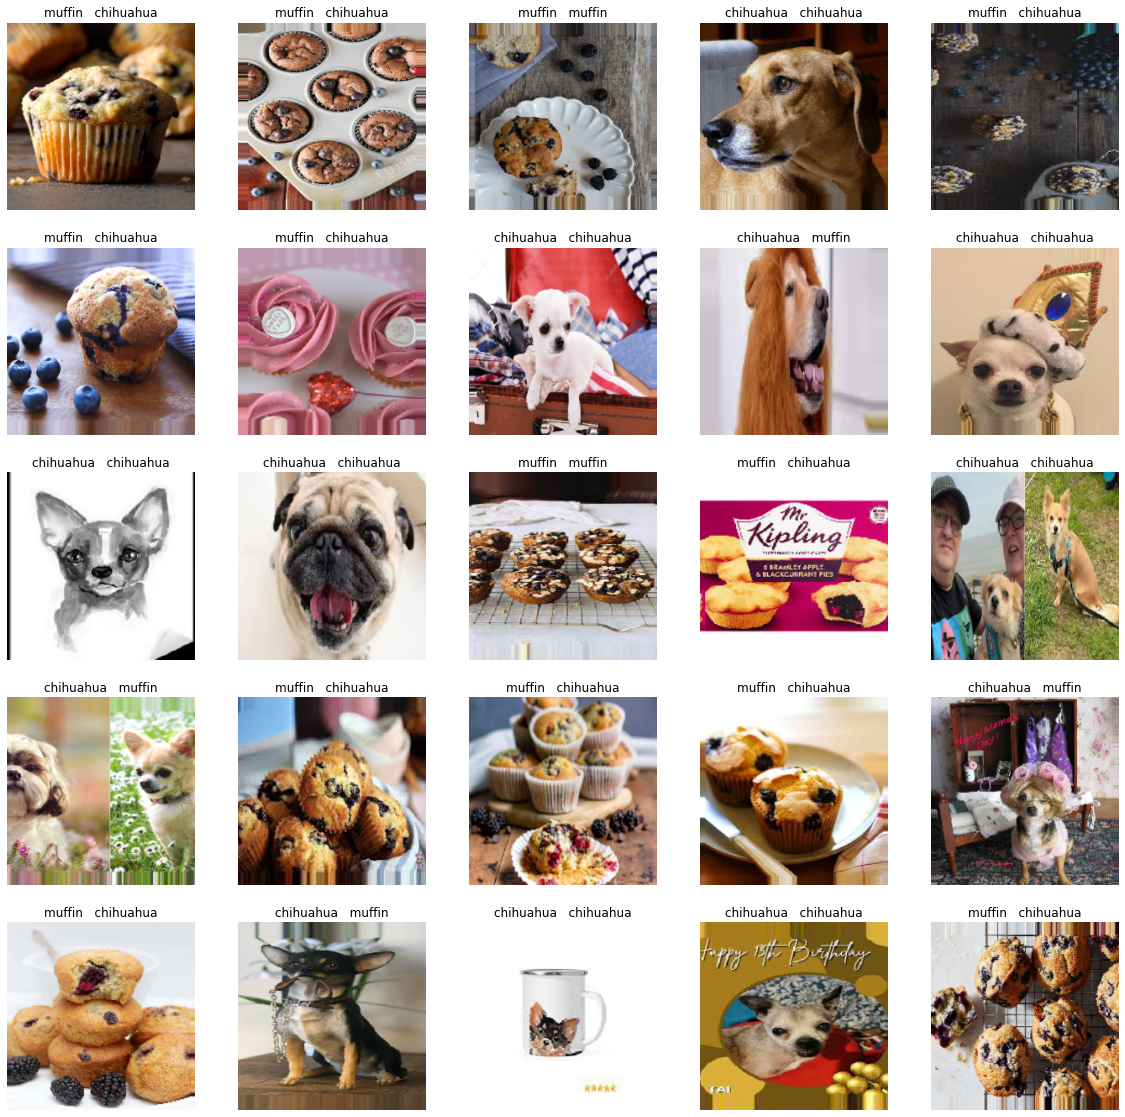

In [20]:
show_images_test(test_gen,prediction)